In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

hist_edges = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
hist_centers = (hist_edges[:-1] + hist_edges[1:]) / 2
hist_values = np.ones(10) / 10  # Uniform distribution over the bins

def hist_entropy(hist_values, hist_centers):
    # Calculate the entropy of the histogram
    hist_values = hist_values / jnp.sum(hist_values)  # Normalize to get probabilities
    entropy = -jnp.sum(hist_values * jnp.log(hist_values + 1e-10))  # Add small value to avoid log(0)
    return entropy

def threshold_constraint(hist_values, hist_centers, threshold=0.5):
    # Calculate the probability mass above the threshold
    above_threshold = hist_centers > threshold
    prob_above_threshold = jnp.sum(hist_values[above_threshold])
    return prob_above_threshold

def smoothness_constraint(hist_values):
    # Encourage smoothness by penalizing large differences between adjacent bins
    diffs = jnp.diff(hist_values)
    smoothness_penalty = jnp.sum(diffs ** 2)
    return smoothness_penalty

def second_order_smoothness_constraint(hist_values):
    diffs = jnp.diff(hist_values, n=2)
    second_order_penalty = jnp.sum(diffs ** 2)
    return second_order_penalty

# use jax to compute the maxent distribution under the constraint that the probability mass above 0.5 is 0.2

# We optimize logits (unnormalized log-probs) to automatically satisfy 
# positivity and sum-to-1 constraints via softmax
logits = jnp.zeros_like(hist_centers) 

def loss_fn(logits):
    probs = jax.nn.softmax(logits)
    # Minimize negative entropy (maximize entropy)
    neg_H = -hist_entropy(probs, hist_centers)
    # Penalty for constraint violation
    prob_above = threshold_constraint(probs, hist_centers, threshold=0.5)
    penalty = (prob_above - 0.2) ** 2
    smoothness_penalty = second_order_smoothness_constraint(probs)
    return neg_H + 100.0 * penalty + 6.0 * smoothness_penalty

# Simple Gradient Descent
learning_rate = 0.5
grad_fn = jax.jit(jax.grad(loss_fn))

for i in range(2000):
    grads = grad_fn(logits)
    logits = logits - learning_rate * grads

hist_values = jax.nn.softmax(logits)

# Verify results
final_prob = threshold_constraint(hist_values, hist_centers, 0.5)
print(f"Final P(X > 0.5): {final_prob:.4f}")
print(f"Max Prob (below 0.5): {jnp.max(hist_values[hist_centers <= 0.5]):.4f}")
print(f"Max Prob (above 0.5): {jnp.max(hist_values[hist_centers > 0.5]):.4f}")

Final P(X > 0.5): 0.2099
Max Prob (below 0.5): 0.1957
Max Prob (above 0.5): 0.0662


In [ ]:
def laplacian_smoothness(hist_values):
    t = 0
    for i in range(len(hist_values.shape)):
        t += jnp.sum(jnp.diff(hist_values, n=1, axis=i) ** 2)
    return t

h = jnp.array([0.1, 0.2, 0.3, 0.4, 0.5]) 
hist_values = h.reshape(1, -1) * h.reshape(-1, 1)
hist_values = hist_values / jnp.sum(hist_values)  # Normalize to get probabilities



print(t)



0.008691358


Text(0.5, 1.0, 'Uniform Distribution over [0, 1]')

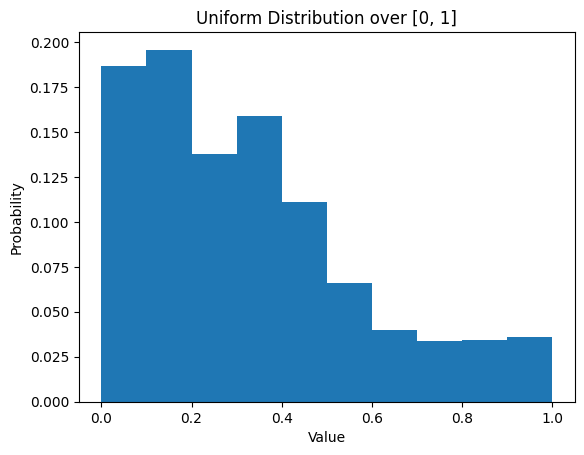

In [15]:
plt.bar(hist_edges[:-1], hist_values, width=0.1, align='edge')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Uniform Distribution over [0, 1]')